# Primary Instructions

Always run this first cell after uploading the adapter.json and trainer.json logs you want to read.

Afterwards run that set of cells that corresponds to the experiment.

Experiment 1: Peak Val Accuracy by Adapter Scope

Experiment 2: Eval Accuracy vs. Step for Different Dropout Rates

Experiment 3: Eval Accuracy vs. Step for Alpha (r*0.5, r*1, r*2)

Experiment 4: Eval Accuracy vs. Step for Different r Values

Experiment 5:  Eval Accuracy vs. Step for Different Learning Rates

In [46]:
import json
import glob
import pandas as pd

# Find all adapter files and store data for lookup
adapter_data_dict = {}
for adapter_file in glob.glob('*_adapter.json'):
    with open(adapter_file, 'r') as f:
        adapter_data = json.load(f)
    adapter_data_dict[adapter_file.replace('_adapter.json', '')] = adapter_data

# Find all trainer files
trainer_files = glob.glob('*_trainer.json')

# Store all DataFrames in a dictionary
all_dfs = {}

for trainer_file in trainer_files:
    with open(trainer_file, 'r') as f:
        trainer_data = json.load(f)

    # Get adapter data for this trainer file
    adapter_key = trainer_file.replace('_trainer.json', '')
    adapter_data = adapter_data_dict.get(adapter_key)

    # # Use these to check to make sure data was read in correctly
    # # Print adapter information
    # print(f"File: {trainer_file}")
    # if adapter_data:
    #     print(f"lora_alpha: {adapter_data.get('lora_alpha')}")
    #     print(f"lora_dropout: {adapter_data.get('lora_dropout')}")
    #     print(f"r: {adapter_data.get('r')}")
    #     print(f"target_modules: {adapter_data.get('target_modules')}")
    # else:
    #     print("Adapter data not found for this trainer file.")

    # Process trainer data (log_history, create DataFrame, etc.)
    log_history = trainer_data.get('log_history', [])
    results = []
    learning_rate = None
    for i in range(0, len(log_history), 2):
        entry = {}
        if i == 0:
          learning_rate = log_history[i].get('learning_rate')
        entry['step'] = log_history[i].get('step')
        entry['loss'] = log_history[i].get('loss')
        raw_loss = log_history[i + 1].get('eval_loss')
        entry['eval_loss'] = f"{raw_loss:.3f}"
        entry['eval_accuracy'] = log_history[i + 1].get('eval_accuracy')
        entry['learning_rate'] = learning_rate
        results.append(entry)

    df = pd.DataFrame(results)

    # Add adapter data as columns (handling list length mismatch)
    if adapter_data:
        for key, value in adapter_data.items():
          if key == 'lora_alpha' or key == 'lora_dropout' or key == 'r' or key == 'target_modules':
            if key == 'target_modules':
                # Assign the entire list to the column, repeating if necessary
                df[key] = [value] * len(df)
            else:
                df[key] = value

    # Store the DataFrame in the dictionary
    all_dfs[trainer_file.replace('_trainer.json', '')] = df

    # # Use these to check to make sure data was read in correctly
    # print(f"DataFrame for {trainer_file}:")
    # display(df)
    # print("-" * 20)  # Separator between files

# Run these to produce chart for Experiment 1

In [16]:
# Store rows with maximum eval_accuracy in a new DataFrame
max_accuracy_rows = []

for trainer_key, df in all_dfs.items():
    # Find the row with maximum eval_accuracy (using .copy() to avoid warning)
    max_row = df.loc[df['eval_accuracy'].idxmax()].copy()

    # Add the trainer_key to the row
    max_row['trainer_key'] = trainer_key

    # Append the row to the list
    max_accuracy_rows.append(max_row)

# Create a new DataFrame from the list of rows
max_accuracy_df = pd.DataFrame(max_accuracy_rows)

# Display the new DataFrame
print("DataFrame with rows having maximum eval_accuracy:")
display(max_accuracy_df)

DataFrame with rows having maximum eval_accuracy:


,step,loss,eval_loss,eval_accuracy,lora_alpha,lora_dropout,r,target_modules,trainer_key
9,1000,0.2788,0.297,0.910937,44,0.05,22,[value],value
8,900,0.2920,0.312,0.904687,22,0.05,11,"[key, value]","key,val"
10,1100,0.3190,0.311,0.901563,44,0.05,22,[query],query
9,1000,0.3160,0.321,0.901563,22,0.05,11,"[key, query]","query,key"
7,800,0.3484,0.321,0.901563,44,0.05,22,[key],key
10,1100,0.2996,0.302,0.910937,22,0.05,11,"[query, value]","query,val"
11,1200,0.3118,0.305,0.909375,14,0.05,7,"[key, query, value]","query,key,val"


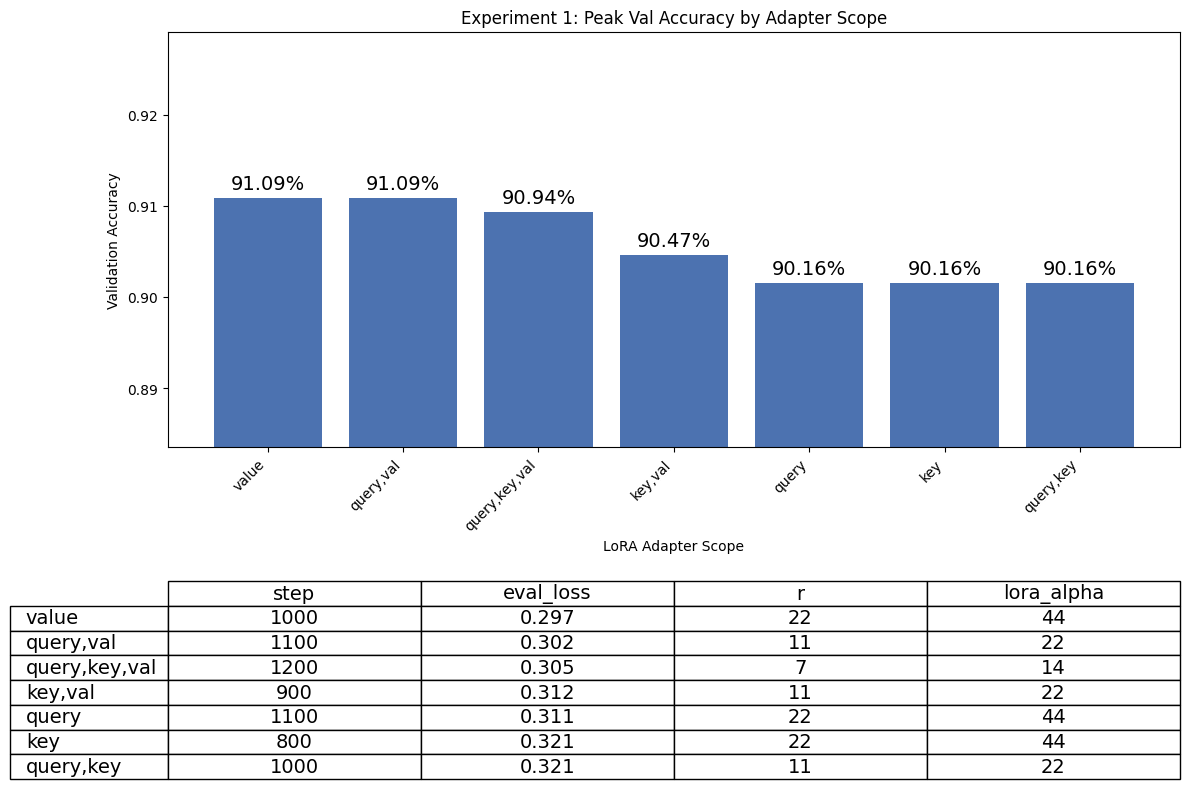

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Sort by accuracy descending
df = max_accuracy_df.sort_values("eval_accuracy", ascending=False).reset_index(drop=True)

keys   = df["trainer_key"]
accs   = df["eval_accuracy"]
steps  = df["step"]
losses = df["eval_loss"]
rs     = df["r"]
alphas = df["lora_alpha"]

# Compute padding
min_acc, max_acc = accs.min(), accs.max()
pad = (max_acc - min_acc) * 0.1
ymin, ymax = min_acc - pad, max_acc + pad

fig = plt.figure(figsize=(12, 8))
gs  = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

# --- Top: bar chart of accuracy ---
ax0 = fig.add_subplot(gs[0])
bars = ax0.bar(df["trainer_key"], df["eval_accuracy"], color="#4C72B0")
ax0.set_ylim(df["eval_accuracy"].min() * 0.98, df["eval_accuracy"].max() * 1.02)
ax0.set_ylabel("Validation Accuracy")
ax0.set_xlabel("LoRA Adapter Scope")
ax0.set_title("Experiment 1: Peak Val Accuracy by Adapter Scope")
plt.setp(ax0.get_xticklabels(), rotation=45, ha="right")

# annotate only the accuracy percentage on each bar
for bar, acc in zip(bars, df["eval_accuracy"]):
    ax0.text(
        bar.get_x() + bar.get_width()/2,
        acc + 0.0005,
        f"{acc*100:.2f}%",
        ha="center",
        va="bottom",
        fontsize=14
    )

# --- Bottom: metadata table ---
ax1 = fig.add_subplot(gs[1])
ax1.axis("off")

# prepare the table dataframe
table_df = df[["step","eval_loss","r","lora_alpha"]].copy()
table_df.index = df["trainer_key"]
table = ax1.table(
    cellText = table_df.values,
    rowLabels= table_df.index,
    colLabels= table_df.columns,
    cellLoc  = "center",
    loc      = "center"
)

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 1.5)

plt.tight_layout(h_pad=2)
plt.show()

# Run these to produce the graph for Experiment 2

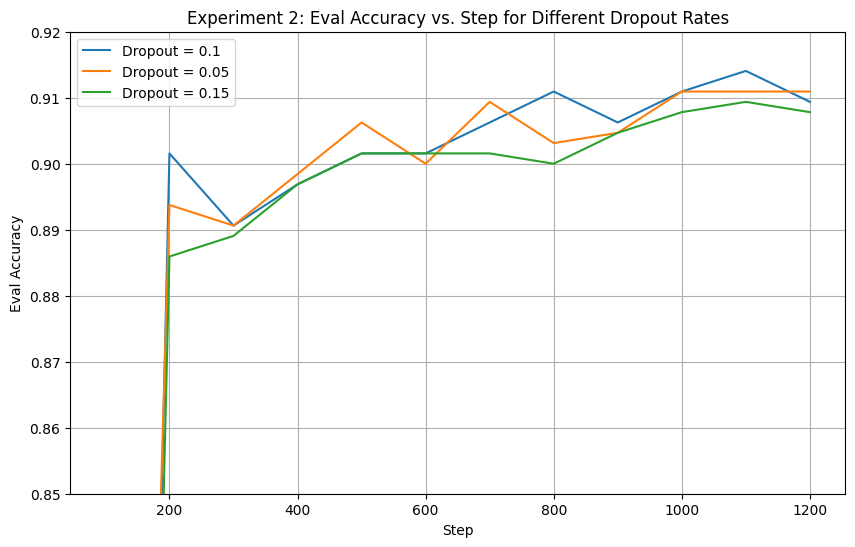

In [22]:
import matplotlib.pyplot as plt


# Create the plot
plt.figure(figsize=(10, 6))

for key, df in all_dfs.items():
    if 'lora_dropout' in df.columns:
        dropout = df['lora_dropout'].iloc[0]  # Assuming dropout is constant for each df
        if dropout in [0.05, 0.1, 0.15]:
            plt.plot(df['step'], df['eval_accuracy'], label=f'Dropout = {dropout}')

plt.xlabel('Step')
plt.ylabel('Eval Accuracy')
plt.title('Experiment 2: Eval Accuracy vs. Step for Different Dropout Rates')
plt.ylim(0.85, 0.92)  # Set y-axis limits for better visualization
plt.legend()
plt.grid(True)
plt.show()

# Run these to produce the graph for Experiment 3



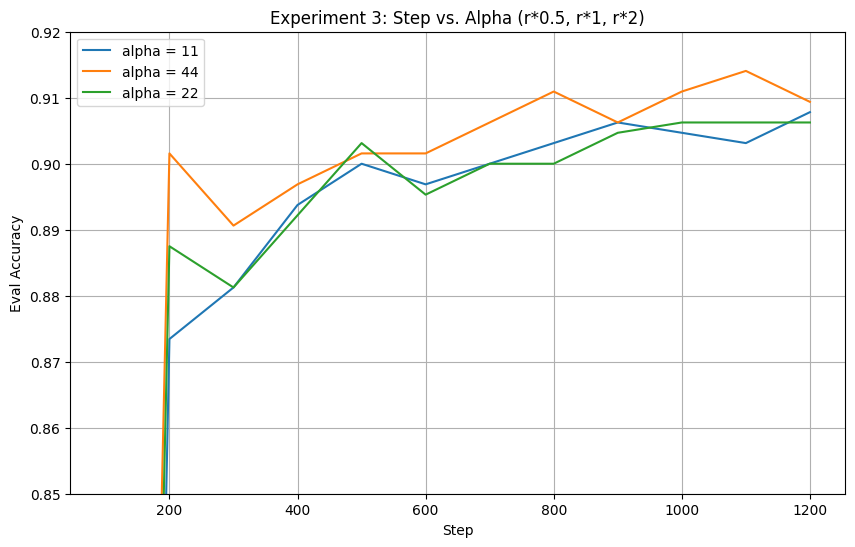

In [35]:
import matplotlib.pyplot as plt
import math

# Create the plot
plt.figure(figsize=(10, 6))

for key, df in all_dfs.items():
    if 'r' in df.columns:
        r_value = df['r'].iloc[0]
        alphas = [math.ceil(r_value * 0.5), r_value * 1, r_value * 2]  # Round up r_value * 0.5
        for alpha in alphas:
          if alpha == df['lora_alpha'].iloc[0]:
            plt.plot(df['step'], df['eval_accuracy'], label=f'alpha = {alpha}')

plt.xlabel('Step')
plt.ylabel('Eval Accuracy')
plt.title('Experiment 3: Step vs. Alpha (r*0.5, r*1, r*2)')
plt.ylim(0.85, 0.92)
plt.legend()
plt.grid(True)
plt.show()


# Run these to produce the graph for Experiment 4



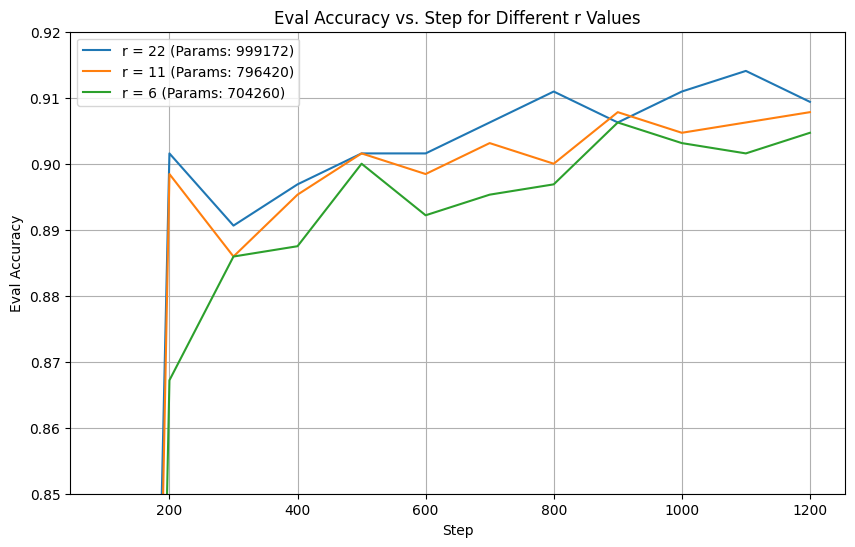

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

r_values = [22, 11, 6]
trainable_params = {22: 999172, 11: 796420, 6: 704260}

for r in r_values:
    for key, df in all_dfs.items():
        if 'r' in df.columns and df['r'].iloc[0] == r:
            plt.plot(df['step'], df['eval_accuracy'], label=f'r = {r} (Params: {trainable_params[r]})')
            break  # Assuming only one DataFrame per r value

plt.xlabel('Step')
plt.ylabel('Eval Accuracy')
plt.title('Eval Accuracy vs. Step for Different r Values')
plt.ylim(0.85, 0.92)
plt.legend()
plt.grid(True)
plt.show()


# Run these to produce the graph for Experiment 5



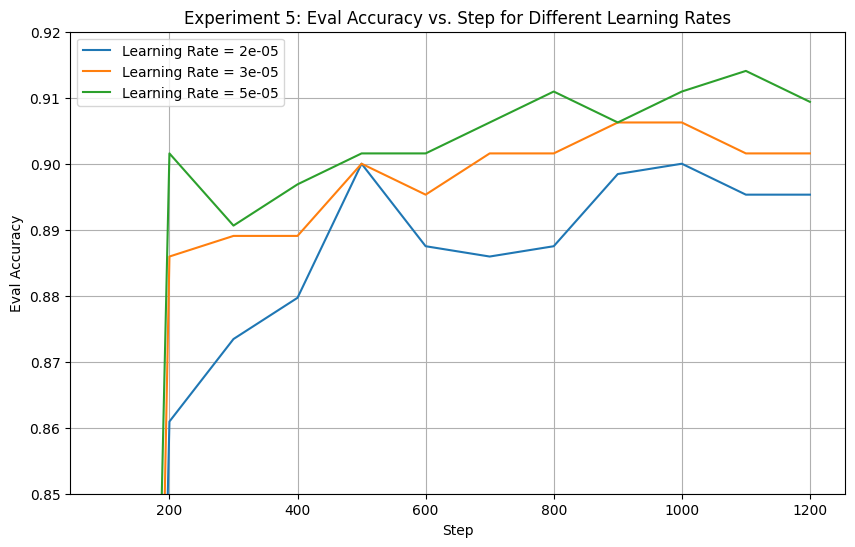

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

learning_rates = [2e-5, 3e-5, 5e-5]

for lr in learning_rates:
    for key, df in all_dfs.items():
        if 'learning_rate' in df.columns and df['learning_rate'].iloc[0] == lr:
            plt.plot(df['step'], df['eval_accuracy'], label=f'Learning Rate = {lr}')

plt.xlabel('Step')
plt.ylabel('Eval Accuracy')
plt.title('Experiment 5: Eval Accuracy vs. Step for Different Learning Rates')
plt.ylim(0.85, 0.92)  # Set y-axis limits for better visualization
plt.legend()
plt.grid(True)
plt.show()
